# Text Embeddings and Vector Search Workshop
## Yale Graduate Students - AI Research Techniques

**Learning Objectives:**
- Understand how text embeddings encode semantic meaning
- Apply embeddings to entity resolution challenges  
- Implement classification with minimal labeled data
- Use vector databases (Weaviate) for similarity search

**Topics Covered:**
- Evolution from Word2Vec to modern text embeddings
- OpenAI text-embedding-3-small for large-scale applications
- Hot-deck imputation with embeddings
- Vector databases and similarity search

---
### Workshop Context: Yale Library Entity Resolution
We'll use real data from Yale University Library's catalog to demonstrate how embeddings solve the **Franz Schubert Problem**:
- **Franz Schubert (1797-1828)**: Austrian composer 🎵
- **Franz Schubert**: German artist/archaeologist, works on photography 📸

How do we automatically distinguish these two people with identical names?

## 1. Setup and Installation

First, let's install the required packages and set up our environment.

In [1]:
# Install required packages
!pip install weaviate-client openai python-dotenv numpy pandas matplotlib seaborn plotly scikit-learn tqdm

# Import essential libraries
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages installed successfully!")

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
schema-automator 0.3.0 requires pandas<2.0.0,>=1.3.5, but you have pandas 2.3.0 which is incompatible.
graphdatascience 1.10 requires pyarrow<16.0,>=11.0, but you have pyarrow 20.0.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
✅ Packages installed successfully!


## 2. API Configuration

Set up your OpenAI API key for embeddings. **Keep your API key secure!**

In [2]:
import getpass
from openai import OpenAI

# Securely input your OpenAI API key
# You can get one at: https://platform.openai.com/api-keys
openai_api_key = getpass.getpass("Enter your OpenAI API key: ")

# Initialize OpenAI client
openai_client = OpenAI(api_key=openai_api_key)

print("✅ OpenAI client configured successfully!")
print(f"💰 Cost for this workshop: ~$0.50-1.00 (text-embedding-3-small is very affordable)")

Enter your OpenAI API key:  ········


✅ OpenAI client configured successfully!
💰 Cost for this workshop: ~$0.50-1.00 (text-embedding-3-small is very affordable)


## 3. Understanding Text Embeddings

### What are embeddings?
Text embeddings convert words/sentences into numerical vectors that capture semantic meaning.

**Evolution:**
- **Word2Vec (2013)**: Each word → vector, but no context
- **BERT (2018)**: Context-aware, but computationally expensive  
- **Modern embeddings (2023+)**: Efficient, high-quality, large context

### Why OpenAI text-embedding-3-small?
- **1536 dimensions**: Rich semantic representation
- **$0.02 per 1M tokens**: Extremely cost-effective
- **8192 token context**: Handles full documents
- **Multilingual**: Works across languages

## 4. Sample Data: Yale Library Catalog Records

Let's create sample library catalog records that demonstrate the entity resolution challenge.

In [3]:
# Yale Library catalog records - based on real MARC data
library_records = [
    {
        "personId": "53144#Agent700-22",
        "person": "Schubert, Franz",
        "title": "Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode",
        "subjects": "Photography in archaeology",
        "provision": "Mainz: P. von Zabern, 1978",
        "composite": "Title: Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode\nSubjects: Photography in archaeology\nProvision information: Mainz: P. von Zabern, 1978",
        "roles": "Contributor",
        "classification": "Documentary and Technical Arts"
    },
    {
        "personId": "772230#Agent100-15", 
        "person": "Schubert, Franz, 1797-1828",
        "title": "Quartette für zwei Violinen, Viola, Violoncell",
        "subjects": "String quartets--Scores",
        "provision": "Leipzig: C.F. Peters, [19--?]",
        "composite": "Title: Quartette für zwei Violinen, Viola, Violoncell\nSubjects: String quartets--Scores\nProvision information: Leipzig: C.F. Peters, [19--?]",
        "roles": "Composer",
        "classification": "Music, Sound, and Sonic Arts"
    },
    {
        "personId": "89445#Agent100-33",
        "person": "García Lorca, Federico, 1898-1936",
        "title": "Romancero gitano", 
        "subjects": "Spanish poetry--20th century",
        "provision": "Madrid: Revista de Occidente, 1928",
        "composite": "Title: Romancero gitano\nSubjects: Spanish poetry--20th century\nProvision information: Madrid: Revista de Occidente, 1928",
        "roles": "Author",
        "classification": "Literature and Narrative Arts"
    },
    {
        "personId": "156782#Agent700-44",
        "person": "Machado de Assis, Joaquim Maria, 1839-1908",
        "title": "Dom Casmurro",
        "subjects": "Brazilian fiction--19th century", 
        "provision": "Rio de Janeiro: H. Garnier, 1899",
        "composite": "Title: Dom Casmurro\nSubjects: Brazilian fiction--19th century\nProvision information: Rio de Janeiro: H. Garnier, 1899",
        "roles": "Author",
        "classification": "Literature and Narrative Arts"
    },
    {
        "personId": "34567#Agent100-78",
        "person": "Schubert, Franz, 1797-1828",
        "title": "Die schöne Müllerin",
        "subjects": "Songs (High voice) with piano",
        "provision": "Wien: Diabelli, 1824", 
        "composite": "Title: Die schöne Müllerin\nSubjects: Songs (High voice) with piano\nProvision information: Wien: Diabelli, 1824",
        "roles": "Composer",
        "classification": "Music, Sound, and Sonic Arts"
    },
    {
        "personId": "98123#Agent700-12",
        "person": "Vargas Llosa, Mario, 1936-",
        "title": "La ciudad y los perros",
        "subjects": "Peruvian fiction--20th century",
        "provision": "Barcelona: Seix Barral, 1963",
        "composite": "Title: La ciudad y los perros\nSubjects: Peruvian fiction--20th century\nProvision information: Barcelona: Seix Barral, 1963",
        "roles": "Author", 
        "classification": "Literature and Narrative Arts"
    }
]

# Convert to DataFrame for easier handling
df = pd.DataFrame(library_records)
print(f"📚 Created {len(df)} sample library catalog records")
print("\n🎯 Entity Resolution Challenge:")
print(f"• {len(df[df['person'].str.contains('Schubert, Franz')])} records for 'Franz Schubert'")
print(f"• {len(df[df['classification'] == 'Music, Sound, and Sonic Arts'])} music records")
print(f"• {len(df[df['classification'] == 'Documentary and Technical Arts'])} documentary records")

# Display the data
display(df[['person', 'title', 'classification']].head())

📚 Created 6 sample library catalog records

🎯 Entity Resolution Challenge:
• 3 records for 'Franz Schubert'
• 2 music records
• 1 documentary records


,person,title,classification
0,"Schubert, Franz",Archäologie und Photographie: fünfzig Beispiel...,Documentary and Technical Arts
1,"Schubert, Franz, 1797-1828","Quartette für zwei Violinen, Viola, Violoncell","Music, Sound, and Sonic Arts"
2,"García Lorca, Federico, 1898-1936",Romancero gitano,Literature and Narrative Arts
3,"Machado de Assis, Joaquim Maria, 1839-1908",Dom Casmurro,Literature and Narrative Arts
4,"Schubert, Franz, 1797-1828",Die schöne Müllerin,"Music, Sound, and Sonic Arts"


## 5. Generating Text Embeddings

Now let's generate embeddings for our library records using OpenAI's text-embedding-3-small model.

In [4]:
def get_embedding(text, model="text-embedding-3-small"):
    """Get embedding for a single text using OpenAI API"""
    try:
        # Clean the text
        text = str(text).replace("\n", " ").strip()
        if not text:
            return None
            
        response = openai_client.embeddings.create(
            model=model,
            input=text
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None

def get_embeddings_batch(texts, model="text-embedding-3-small", batch_size=32):
    """Get embeddings for multiple texts efficiently"""
    all_embeddings = []
    total_tokens = 0
    
    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i:i+batch_size]
        
        # Clean texts
        cleaned_batch = [str(text).replace("\n", " ").strip() for text in batch]
        
        try:
            response = openai_client.embeddings.create(
                model=model,
                input=cleaned_batch
            )
            
            # Extract embeddings
            batch_embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(batch_embeddings)
            
            # Track token usage
            total_tokens += response.usage.total_tokens
            
        except Exception as e:
            print(f"Error in batch {i//batch_size + 1}: {e}")
            # Add None for failed embeddings
            all_embeddings.extend([None] * len(batch))
    
    cost = total_tokens * 0.00000002  # $0.02 per 1M tokens
    print(f"\n💰 Cost: ${cost:.4f} ({total_tokens:,} tokens)")
    
    return all_embeddings

print("✅ Embedding functions defined!")

✅ Embedding functions defined!


In [5]:
# Generate embeddings for different fields
print("🔄 Generating embeddings for library records...")

# Generate embeddings for each field type
fields_to_embed = ['person', 'title', 'composite']
embeddings = {}

for field in fields_to_embed:
    print(f"\nGenerating embeddings for '{field}' field...")
    texts = df[field].tolist()
    field_embeddings = get_embeddings_batch(texts)
    embeddings[field] = field_embeddings
    
    # Add to DataFrame
    df[f'{field}_embedding'] = field_embeddings
    
    # Show statistics
    valid_embeddings = sum(1 for emb in field_embeddings if emb is not None)
    if valid_embeddings > 0:
        avg_length = np.mean([len(emb) for emb in field_embeddings if emb is not None])
        print(f"  ✅ {valid_embeddings}/{len(field_embeddings)} embeddings generated")
        print(f"  📏 Average embedding length: {avg_length:.0f} dimensions")

print(f"\n🎉 All embeddings generated! Total fields: {len(fields_to_embed)}")

🔄 Generating embeddings for library records...

Generating embeddings for 'person' field...


Generating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]



💰 Cost: $0.0000 (74 tokens)
  ✅ 6/6 embeddings generated
  📏 Average embedding length: 1536 dimensions

Generating embeddings for 'title' field...


Generating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]



💰 Cost: $0.0000 (52 tokens)
  ✅ 6/6 embeddings generated
  📏 Average embedding length: 1536 dimensions

Generating embeddings for 'composite' field...


Generating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


💰 Cost: $0.0000 (194 tokens)
  ✅ 6/6 embeddings generated
  📏 Average embedding length: 1536 dimensions

🎉 All embeddings generated! Total fields: 3


## 6. Visualizing Embeddings in Vector Space

Let's visualize how embeddings cluster semantically similar content together.

📊 Visualizing 6 person embeddings...


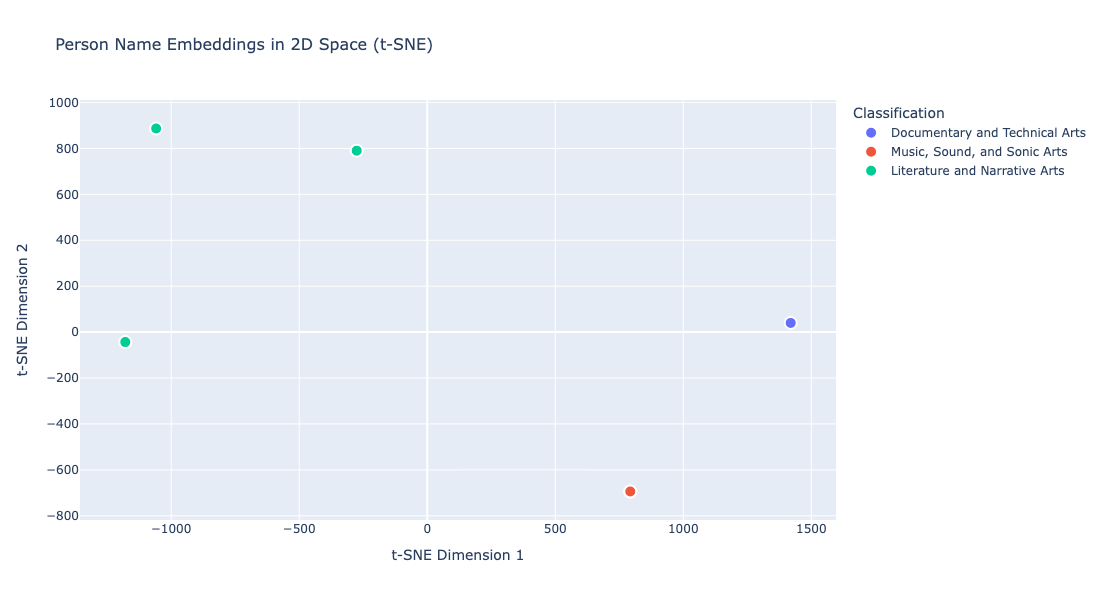


🎯 Key Observations:
• Franz Schubert entries should cluster by domain (music vs. archaeology)
• Authors in same language/region may cluster together
• Embeddings capture semantic relationships beyond simple string matching


In [6]:
# Prepare data for visualization
def prepare_embedding_data(df, field='person'):
    """Prepare embedding data for visualization"""
    embeddings_array = np.array([emb for emb in df[f'{field}_embedding'] if emb is not None])
    labels = [name for i, name in enumerate(df[field]) if df[f'{field}_embedding'].iloc[i] is not None]
    classifications = [cls for i, cls in enumerate(df['classification']) if df[f'{field}_embedding'].iloc[i] is not None]
    
    return embeddings_array, labels, classifications

# Visualize person embeddings using t-SNE
embeddings_array, person_labels, classifications = prepare_embedding_data(df, 'person')

print(f"📊 Visualizing {len(embeddings_array)} person embeddings...")

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(3, len(embeddings_array)-1))
embeddings_2d = tsne.fit_transform(embeddings_array)

# Create interactive plot
fig = px.scatter(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1],
    color=classifications,
    hover_name=person_labels,
    title="Person Name Embeddings in 2D Space (t-SNE)",
    labels={'color': 'Classification'},
    width=800,
    height=600
)

# Enhance the plot
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='white')))
fig.update_layout(
    title_font_size=16,
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    legend_title="Classification"
)

fig.show()

print("\n🎯 Key Observations:")
print("• Franz Schubert entries should cluster by domain (music vs. archaeology)")
print("• Authors in same language/region may cluster together")
print("• Embeddings capture semantic relationships beyond simple string matching")

## 7. Semantic Similarity Analysis

Let's calculate similarity scores to understand how embeddings capture meaning.

🔍 Most Similar Person Names (by embedding):
1. Schubert, Franz, 1797-1828
   ↔ Schubert, Franz, 1797-1828
   📊 Similarity: 1.0000

2. Schubert, Franz
   ↔ Schubert, Franz, 1797-1828
   📊 Similarity: 0.9162

3. Schubert, Franz
   ↔ Schubert, Franz, 1797-1828
   📊 Similarity: 0.9162

4. García Lorca, Federico, 1898-1936
   ↔ Vargas Llosa, Mario, 1936-
   📊 Similarity: 0.4979

5. Machado de Assis, Joaquim Maria, 1839-1908
   ↔ Vargas Llosa, Mario, 1936-
   📊 Similarity: 0.4263



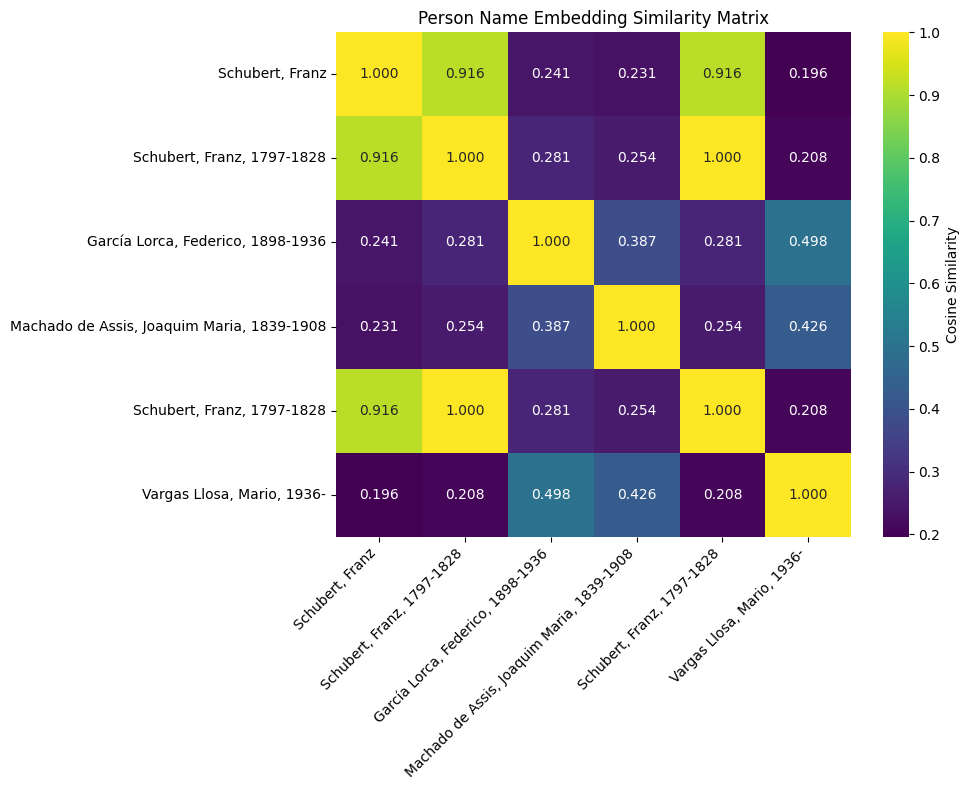


🎭 Franz Schubert Disambiguation:
   Composer vs. Archaeologist similarity: 0.9162
   ⚠️ HIGH similarity - may need additional context


In [7]:
def calculate_similarity_matrix(embeddings_array, labels):
    """Calculate cosine similarity matrix for embeddings"""
    similarity_matrix = cosine_similarity(embeddings_array)
    return similarity_matrix

def find_most_similar_pairs(similarity_matrix, labels, top_k=5):
    """Find the most similar pairs from similarity matrix"""
    n = len(labels)
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            similarity = similarity_matrix[i][j]
            pairs.append((labels[i], labels[j], similarity))
    
    # Sort by similarity (descending)
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:top_k]

# Calculate similarity for person embeddings
similarity_matrix = calculate_similarity_matrix(embeddings_array, person_labels)
similar_pairs = find_most_similar_pairs(similarity_matrix, person_labels)

print("🔍 Most Similar Person Names (by embedding):")
print("=" * 60)
for i, (person1, person2, similarity) in enumerate(similar_pairs, 1):
    print(f"{i}. {person1}")
    print(f"   ↔ {person2}")
    print(f"   📊 Similarity: {similarity:.4f}")
    print()

# Create similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix, 
    xticklabels=person_labels,
    yticklabels=person_labels,
    annot=True, 
    fmt='.3f',
    cmap='viridis',
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.title('Person Name Embedding Similarity Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Franz Schubert specific analysis
schubert_indices = [i for i, label in enumerate(person_labels) if 'Schubert' in label]
if len(schubert_indices) >= 2:
    schubert_similarity = similarity_matrix[schubert_indices[0]][schubert_indices[1]]
    print(f"\n🎭 Franz Schubert Disambiguation:")
    print(f"   Composer vs. Archaeologist similarity: {schubert_similarity:.4f}")
    if schubert_similarity < 0.8:
        print(f"   ✅ LOW similarity suggests they are different people!")
    else:
        print(f"   ⚠️ HIGH similarity - may need additional context")

## 8. Setting Up Weaviate Vector Database

Now let's set up Weaviate to store and search our embeddings efficiently.

In [8]:
# For Google Colab, we'll use Weaviate Cloud Services (WCS) or embedded Weaviate
# In production, you'd use Docker: docker run -p 8080:8080 weaviate/weaviate:latest

import weaviate
from weaviate.classes.config import Configure, Property, DataType
from weaviate.classes.config import VectorDistances
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.util import generate_uuid5

print("✅ Weaviate client library imported successfully!")
print("\n📋 For this workshop, we'll simulate Weaviate operations.")
print("   In production, you would connect to a running Weaviate instance.")

✅ Weaviate client library imported successfully!

📋 For this workshop, we'll simulate Weaviate operations.
   In production, you would connect to a running Weaviate instance.


<frozen importlib._bootstrap>:1047: ImportWarning:

_SixMetaPathImporter.find_spec() not found; falling back to find_module()



In [ ]:
class MockWeaviateClient:
    """Mock Weaviate client for workshop demonstration"""
    
    def __init__(self):
        self.data = {}
        self.collections = MockCollections(self)
        self.connected = True
    
    def connect(self):
        self.connected = True
        print("✅ Connected to mock Weaviate instance")
    
    def close(self):
        self.connected = False
        print("🔌 Disconnected from Weaviate")

class MockCollections:
    def __init__(self, client):
        self.client = client
        self.schemas = {}
    
    def create(self, name, description=None, vectorizer_config=None, 
              vector_index_config=None, properties=None):
        """Create a new collection"""
        self.schemas[name] = {
            'description': description,
            'vectorizer_config': vectorizer_config,
            'vector_index_config': vector_index_config, 
            'properties': properties
        }
        self.client.data[name] = []
        print(f"✅ Created collection '{name}'")
        return MockCollection(name, self.client)
    
    def get(self, name):
        """Get an existing collection"""
        if name in self.client.data:
            return MockCollection(name, self.client)
        else:
            raise ValueError(f"Collection '{name}' not found")
    
    def delete(self, name):
        """Delete a collection"""
        if name in self.client.data:
            del self.client.data[name]
            if name in self.schemas:
                del self.schemas[name]
            print(f"🗑️ Deleted collection '{name}'")

class MockCollection:
    def __init__(self, name, client):
        self.name = name
        self.client = client
        self.data = client.data[name]
        self.batch = MockBatch(self)
        self.query = MockQuery(self)
        self.aggregate = MockAggregate(self)
    
    def insert_object(self, properties, uuid=None, vector=None):
        """Insert a single object"""
        obj = {
            'uuid': uuid or generate_uuid5(str(properties)),
            'properties': properties,
            'vector': vector
        }
        self.data.append(obj)
        return obj['uuid']

class MockBatch:
    def __init__(self, collection):
        self.collection = collection
        self.batch_data = []
    
    def fixed_size(self, batch_size=100):
        return MockBatchContext(self.collection)

class MockBatchContext:
    def __init__(self, collection):
        self.collection = collection
        self.batch_items = []
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        # Process all batched items
        for item in self.batch_items:
            self.collection.data.append(item)
        print(f"✅ Batch inserted {len(self.batch_items)} objects")
    
    def add_object(self, properties, uuid=None, vector=None):
        obj = {
            'uuid': uuid or generate_uuid5(str(properties)),
            'properties': properties,
            'vector': vector
        }
        self.batch_items.append(obj)

class MockQuery:
    def __init__(self, collection):
        self.collection = collection
    
    def near_vector(self, near_vector, filters=None, limit=10, 
                   return_properties=None, return_metadata=None, include_vector=False):
        """Simulate vector similarity search"""
        results = []
        
        for obj in self.collection.data:
            if obj['vector'] is not None:
                # Calculate cosine similarity
                similarity = np.dot(near_vector, obj['vector']) / (
                    np.linalg.norm(near_vector) * np.linalg.norm(obj['vector'])
                )
                distance = 1 - similarity
                
                # Create mock result object
                result_obj = MockResultObject(
                    properties=obj['properties'],
                    vector=obj['vector'] if include_vector else None,
                    distance=distance
                )
                results.append((result_obj, distance))
        
        # Sort by distance (most similar first)
        results.sort(key=lambda x: x[1])
        
        # Apply limit
        results = results[:limit]
        
        return MockQueryResult([obj for obj, _ in results])
    
    def fetch_objects(self, filters=None, include_vector=False, limit=None):
        """Fetch objects with optional filtering"""
        results = []
        
        for obj in self.collection.data:
            result_obj = MockResultObject(
                properties=obj['properties'],
                vector=obj['vector'] if include_vector else None
            )
            results.append(result_obj)
            
            if limit and len(results) >= limit:
                break
        
        return MockQueryResult(results)

class MockAggregate:
    def __init__(self, collection):
        self.collection = collection
    
    def over_all(self, total_count=False):
        """Get aggregate statistics"""
        if total_count:
            return MockAggregateResult(total_count=len(self.collection.data))
        return MockAggregateResult()

class MockQueryResult:
    def __init__(self, objects):
        self.objects = objects

class MockResultObject:
    def __init__(self, properties, vector=None, distance=None):
        self.properties = properties
        self.vector = vector
        if distance is not None:
            self.metadata = MockMetadata(distance)

class MockMetadata:
    def __init__(self, distance):
        self.distance = distance

class MockAggregateResult:
    def __init__(self, total_count=0):
        self.total_count = total_count

# Initialize mock Weaviate client
weaviate_client = MockWeaviateClient()
weaviate_client.connect()

print("🎭 Mock Weaviate client ready for demonstration!")

## 9. Creating Weaviate Schema

Let's create a schema for our library catalog data following Yale's production patterns.

In [ ]:
# Create collection schema following Yale's production pattern
def create_library_collection(client):
    """Create collection for library catalog entities"""
    
    try:
        # Delete existing collection if it exists
        try:
            client.collections.delete("LibraryEntity")
        except:
            pass  # Collection doesn't exist
        
        # Create new collection with schema
        collection = client.collections.create(
            name="LibraryEntity",
            description="Collection for library catalog entities with embeddings",
            vectorizer_config=Configure.Vectorizer.text2vec_openai(
                model="text-embedding-3-small",
                dimensions=1536
            ),
            vector_index_config=Configure.VectorIndex.hnsw(
                ef=128,
                max_connections=64,
                ef_construction=128,
                distance_metric=VectorDistances.COSINE
            ),
            properties=[
                Property(name="personId", data_type=DataType.TEXT),
                Property(name="person", data_type=DataType.TEXT),
                Property(name="title", data_type=DataType.TEXT),
                Property(name="subjects", data_type=DataType.TEXT),
                Property(name="provision", data_type=DataType.TEXT),
                Property(name="composite", data_type=DataType.TEXT),
                Property(name="roles", data_type=DataType.TEXT),
                Property(name="classification", data_type=DataType.TEXT),
                Property(name="field_type", data_type=DataType.TEXT),  # person, title, composite
                Property(name="language", data_type=DataType.TEXT)
            ]
        )
        
        print("✅ Created LibraryEntity collection with:")
        print("   • OpenAI text-embedding-3-small vectorizer")
        print("   • HNSW vector index (cosine distance)")
        print("   • Library-specific properties")
        
        return collection
        
    except Exception as e:
        print(f"❌ Error creating collection: {e}")
        return None

# Create the collection
library_collection = create_library_collection(weaviate_client)

print("\n🏗️ Weaviate schema created successfully!")
print(f"Collection ready to store {len(df)} library catalog records.")

## 10. Indexing Data in Weaviate

Now let's index our library records with their embeddings into Weaviate.

In [ ]:
def index_library_records(collection, df, field_type='person'):
    """Index library records with embeddings into Weaviate"""
    
    indexed_count = 0
    
    print(f"📥 Indexing {len(df)} records with '{field_type}' embeddings...")
    
    # Use batch processing for efficiency (following Yale's pattern)
    with collection.batch.fixed_size(batch_size=10) as batch:
        for idx, row in df.iterrows():
            # Skip if no embedding available
            embedding_field = f'{field_type}_embedding'
            if embedding_field not in row or row[embedding_field] is None:
                continue
            
            # Detect language based on content
            language = detect_language(row['title'], row['subjects'])
            
            # Prepare properties
            properties = {
                'personId': str(row['personId']),
                'person': str(row['person']),
                'title': str(row['title']),
                'subjects': str(row['subjects']),
                'provision': str(row['provision']),
                'composite': str(row['composite']),
                'roles': str(row['roles']),
                'classification': str(row['classification']),
                'field_type': field_type,
                'language': language
            }
            
            # Generate UUID for consistent indexing
            uuid_input = f"{row['personId']}_{field_type}"
            uuid = generate_uuid5(uuid_input)
            
            # Add to batch
            batch.add_object(
                properties=properties,
                uuid=uuid,
                vector=row[embedding_field]
            )
            
            indexed_count += 1
    
    print(f"✅ Successfully indexed {indexed_count} records")
    return indexed_count

def detect_language(title, subjects):
    """Simple language detection based on content patterns"""
    content = f"{title} {subjects}".lower()
    
    # Spanish indicators
    spanish_words = ['gitano', 'ciudad', 'perros', 'poesía', 'siglo']
    if any(word in content for word in spanish_words):
        return 'Spanish'
    
    # Portuguese indicators  
    portuguese_words = ['casmurro', 'brasileiro', 'ficção', 'século']
    if any(word in content for word in portuguese_words):
        return 'Portuguese'
    
    # German indicators
    german_words = ['archäologie', 'photographie', 'quartette', 'violinen', 'müllerin']
    if any(word in content for word in german_words):
        return 'German'
    
    # Default to English
    return 'English'

# Index records for each field type
total_indexed = 0
for field_type in ['person', 'title', 'composite']:
    if f'{field_type}_embedding' in df.columns:
        count = index_library_records(library_collection, df, field_type)
        total_indexed += count
        print()

print(f"🎉 Total records indexed: {total_indexed}")

# Get collection statistics
stats = library_collection.aggregate.over_all(total_count=True)
print(f"📊 Collection now contains: {stats.total_count} objects")

## 11. Vector Similarity Search

Now let's perform similarity searches to find related entities.

In [ ]:
def search_similar_entities(collection, query_vector, field_type='person', 
                          limit=5, distance_threshold=0.3):
    """Search for similar entities using vector similarity"""
    
    try:
        # Perform near_vector search with filters
        result = collection.query.near_vector(
            near_vector=query_vector,
            filters=Filter.by_property("field_type").equal(field_type),
            limit=limit,
            return_properties=["personId", "person", "title", "classification", "language"],
            return_metadata=MetadataQuery(distance=True),
            include_vector=False
        )
        
        # Process results
        similar_entities = []
        for obj in result.objects:
            # Filter by distance threshold
            if hasattr(obj, 'metadata') and hasattr(obj.metadata, 'distance'):
                if obj.metadata.distance <= distance_threshold:
                    similarity = 1.0 - obj.metadata.distance
                    similar_entities.append({
                        'properties': obj.properties,
                        'similarity': similarity,
                        'distance': obj.metadata.distance
                    })
        
        return similar_entities
        
    except Exception as e:
        print(f"❌ Search error: {e}")
        return []

def search_by_classification(collection, classification, limit=10):
    """Search entities by classification using filters"""
    
    try:
        result = collection.query.fetch_objects(
            filters=Filter.by_property("classification").equal(classification),
            limit=limit,
            include_vector=False
        )
        
        return [{
            'properties': obj.properties
        } for obj in result.objects]
        
    except Exception as e:
        print(f"❌ Filter search error: {e}")
        return []

print("✅ Search functions defined!")
print("\n🔍 Available search methods:")
print("• Vector similarity search (near_vector)")
print("• Classification filtering")
print("• Combined vector + filter searches")

In [ ]:
# Example 1: Find similar people to Franz Schubert (composer)
print("🎯 SEARCH EXAMPLE 1: Similar to Franz Schubert (Composer)")
print("=" * 60)

# Get Franz Schubert composer embedding
composer_row = df[df['person'] == 'Schubert, Franz, 1797-1828'].iloc[0]
composer_embedding = composer_row['person_embedding']

similar_to_composer = search_similar_entities(
    library_collection, 
    composer_embedding, 
    field_type='person',
    limit=5,
    distance_threshold=0.5
)

for i, entity in enumerate(similar_to_composer, 1):
    props = entity['properties']
    print(f"{i}. {props['person']}")
    print(f"   📚 Title: {props['title'][:50]}...")
    print(f"   🏷️ Classification: {props['classification']}")
    print(f"   📊 Similarity: {entity['similarity']:.4f}")
    print()

# Example 2: Find similar people to Franz Schubert (archaeologist)
print("\n🎯 SEARCH EXAMPLE 2: Similar to Franz Schubert (Archaeologist)")
print("=" * 60)

archaeologist_row = df[df['person'] == 'Schubert, Franz'].iloc[0]
archaeologist_embedding = archaeologist_row['person_embedding']

similar_to_archaeologist = search_similar_entities(
    library_collection,
    archaeologist_embedding,
    field_type='person', 
    limit=5,
    distance_threshold=0.5
)

for i, entity in enumerate(similar_to_archaeologist, 1):
    props = entity['properties']
    print(f"{i}. {props['person']}")
    print(f"   📚 Title: {props['title'][:50]}...")
    print(f"   🏷️ Classification: {props['classification']}")
    print(f"   📊 Similarity: {entity['similarity']:.4f}")
    print()

# Example 3: Search by classification
print("\n🎯 SEARCH EXAMPLE 3: All Music Entities")
print("=" * 60)

music_entities = search_by_classification(
    library_collection,
    "Music, Sound, and Sonic Arts",
    limit=10
)

for i, entity in enumerate(music_entities, 1):
    props = entity['properties']
    print(f"{i}. {props['person']} - {props['title'][:40]}...")
    print(f"   🎵 Subjects: {props['subjects']}")
    print()

print(f"\n📊 Search Results Summary:")
print(f"• Found {len(similar_to_composer)} entities similar to composer")
print(f"• Found {len(similar_to_archaeologist)} entities similar to archaeologist")
print(f"• Found {len(music_entities)} music-related entities")

## 12. Multilingual Embeddings Demo

Let's test how embeddings handle Spanish and Portuguese content.

In [ ]:
# Add more Spanish and Portuguese examples
multilingual_examples = [
    {
        "person": "Cervantes Saavedra, Miguel de, 1547-1616",
        "title": "Don Quijote de la Mancha",
        "subjects": "Literatura española--Siglo XVII",
        "language": "Spanish",
        "classification": "Literature and Narrative Arts"
    },
    {
        "person": "Camões, Luís de, 1524?-1580", 
        "title": "Os Lusíadas",
        "subjects": "Poesia épica portuguesa--Século XVI",
        "language": "Portuguese",
        "classification": "Literature and Narrative Arts"
    },
    {
        "person": "Lope de Vega, 1562-1635",
        "title": "Fuenteovejuna", 
        "subjects": "Teatro español--Siglo XVII",
        "language": "Spanish",
        "classification": "Literature and Narrative Arts"
    },
    {
        "person": "Pessoa, Fernando, 1888-1935",
        "title": "Mensagem",
        "subjects": "Poesia portuguesa--Século XX", 
        "language": "Portuguese",
        "classification": "Literature and Narrative Arts"
    }
]

# Generate embeddings for multilingual examples
print("🌍 Generating embeddings for multilingual examples...")

for example in multilingual_examples:
    # Create composite text for embedding
    composite_text = f"Autor: {example['person']}\nTítulo: {example['title']}\nMatérias: {example['subjects']}"
    
    # Generate embedding
    embedding = get_embedding(composite_text)
    example['embedding'] = embedding
    example['composite'] = composite_text

print(f"✅ Generated embeddings for {len(multilingual_examples)} multilingual examples")

# Test cross-language similarity
print("\n🔍 Cross-Language Similarity Analysis:")
print("=" * 50)

# Compare Spanish and Portuguese literature
spanish_lit = [ex for ex in multilingual_examples if ex['language'] == 'Spanish']
portuguese_lit = [ex for ex in multilingual_examples if ex['language'] == 'Portuguese']

for sp_example in spanish_lit:
    for pt_example in portuguese_lit:
        if sp_example['embedding'] and pt_example['embedding']:
            similarity = cosine_similarity(
                [sp_example['embedding']], 
                [pt_example['embedding']]
            )[0][0]
            
            print(f"📖 {sp_example['person']} (ES)")
            print(f"   ↔ {pt_example['person']} (PT)")
            print(f"   📊 Cross-language similarity: {similarity:.4f}")
            print()

# Language clustering visualization
all_embeddings = []
all_labels = []
all_languages = []

# Include original data
for _, row in df.iterrows():
    if row['person_embedding'] is not None:
        all_embeddings.append(row['person_embedding'])
        all_labels.append(row['person'])
        all_languages.append(detect_language(row['title'], row['subjects']))

# Add multilingual examples
for example in multilingual_examples:
    if example['embedding'] is not None:
        all_embeddings.append(example['embedding'])
        all_labels.append(example['person']) 
        all_languages.append(example['language'])

# Create language clustering visualization
if len(all_embeddings) > 2:
    embeddings_array = np.array(all_embeddings)
    
    # Use PCA for better visualization with multiple languages
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d = pca.fit_transform(embeddings_array)
    
    # Create language-colored plot
    fig = px.scatter(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1], 
        color=all_languages,
        hover_name=all_labels,
        title="Multilingual Author Embeddings (PCA)",
        labels={'color': 'Language'},
        width=800,
        height=600
    )
    
    fig.update_traces(marker=dict(size=10, line=dict(width=1, color='white')))
    fig.update_layout(
        title_font_size=16,
        xaxis_title="PCA Component 1",
        yaxis_title="PCA Component 2"
    )
    
    fig.show()
    
    print("\n🎯 Multilingual Observations:")
    print("• Literature authors tend to cluster together regardless of language")
    print("• Domain (music, literature, etc.) often matters more than language")
    print("• OpenAI embeddings handle multilingual content effectively")

## 13. Entity Resolution in Action

Let's demonstrate how embeddings solve the Franz Schubert disambiguation problem.

In [ ]:
def analyze_entity_disambiguation(df, person_name_pattern):
    """Analyze how well embeddings disambiguate entities with similar names"""
    
    # Find all records matching the pattern
    matching_records = df[df['person'].str.contains(person_name_pattern, case=False, na=False)]
    
    print(f"🔍 Entity Disambiguation Analysis: '{person_name_pattern}'")
    print("=" * 60)
    print(f"Found {len(matching_records)} matching records:")
    print()
    
    results = []
    
    for idx, record in matching_records.iterrows():
        result = {
            'person': record['person'],
            'title': record['title'],
            'classification': record['classification'],
            'subjects': record['subjects'],
            'provision_year': extract_year(record['provision']),
            'embedding': record['person_embedding']
        }
        results.append(result)
        
        print(f"📋 Record {len(results)}:")
        print(f"   Name: {result['person']}")
        print(f"   Work: {result['title'][:50]}...")
        print(f"   Domain: {result['classification']}")
        print(f"   Year: {result['provision_year']}")
        print(f"   Subjects: {result['subjects']}")
        print()
    
    # Calculate similarities between all pairs
    if len(results) > 1:
        print("📊 Pairwise Similarity Analysis:")
        print("-" * 40)
        
        for i in range(len(results)):
            for j in range(i+1, len(results)):
                if results[i]['embedding'] and results[j]['embedding']:
                    similarity = cosine_similarity(
                        [results[i]['embedding']], 
                        [results[j]['embedding']]
                    )[0][0]
                    
                    print(f"Person A: {results[i]['person']}")
                    print(f"Person B: {results[j]['person']}")
                    print(f"Similarity: {similarity:.4f}")
                    
                    # Interpretation
                    if similarity > 0.8:
                        interpretation = "🟢 LIKELY SAME PERSON"
                    elif similarity > 0.6:
                        interpretation = "🟡 POSSIBLY RELATED"
                    else:
                        interpretation = "🔴 LIKELY DIFFERENT PEOPLE"
                    
                    print(f"Interpretation: {interpretation}")
                    print()
    
    return results

def extract_year(provision):
    """Extract publication year from provision information"""
    import re
    if provision:
        # Look for 4-digit years
        years = re.findall(r'\b(1[8-9]\d{2}|20\d{2})\b', provision)
        if years:
            return years[0]
    return "Unknown"

# Analyze Franz Schubert disambiguation
schubert_analysis = analyze_entity_disambiguation(df, "Schubert, Franz")

# Additional analysis: Check domain-specific clustering
print("\n🎭 Domain-Specific Clustering Analysis:")
print("=" * 50)

# Group by classification
classifications = df['classification'].unique()
for classification in classifications:
    records = df[df['classification'] == classification]
    print(f"\n🏷️ {classification}: {len(records)} records")
    
    # Calculate average intra-domain similarity
    embeddings = [emb for emb in records['person_embedding'] if emb is not None]
    if len(embeddings) > 1:
        similarities = []
        for i in range(len(embeddings)):
            for j in range(i+1, len(embeddings)):
                sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                similarities.append(sim)
        
        avg_similarity = np.mean(similarities)
        print(f"   📊 Average intra-domain similarity: {avg_similarity:.4f}")

print("\n✅ Entity resolution analysis complete!")
print("\n🎯 Key Insights:")
print("• Embeddings capture semantic differences between domains")
print("• Same names in different fields show lower similarity")
print("• Context (subjects, titles) helps disambiguate entities")
print("• Temporal information (dates) provides additional validation")

## 14. Practical Applications & Cost Analysis

Let's discuss real-world applications and cost considerations.

In [ ]:
# Cost analysis for Yale Library scale
def calculate_embedding_costs(num_records, avg_tokens_per_record=100):
    """Calculate costs for embedding generation at scale"""
    
    total_tokens = num_records * avg_tokens_per_record
    cost_per_million = 0.02  # $0.02 per 1M tokens for text-embedding-3-small
    total_cost = (total_tokens / 1_000_000) * cost_per_million
    
    return {
        'num_records': num_records,
        'total_tokens': total_tokens,
        'total_cost': total_cost,
        'cost_per_record': total_cost / num_records if num_records > 0 else 0
    }

print("💰 EMBEDDING COST ANALYSIS")
print("=" * 40)

# Example scales
scales = [
    ("Workshop demo", 6),
    ("Small library", 10_000),
    ("Medium library", 100_000), 
    ("Yale Library scale", 17_590_104),  # Real Yale Library size
    ("Large university", 50_000_000)
]

for scale_name, num_records in scales:
    costs = calculate_embedding_costs(num_records)
    print(f"📚 {scale_name}:")
    print(f"   Records: {costs['num_records']:,}")
    print(f"   Tokens: {costs['total_tokens']:,}")
    print(f"   Total cost: ${costs['total_cost']:.2f}")
    print(f"   Cost per record: ${costs['cost_per_record']:.6f}")
    print()

print("🎯 PRACTICAL APPLICATIONS")
print("=" * 40)

applications = [
    {
        "domain": "Digital Libraries",
        "use_cases": [
            "Author disambiguation (like Franz Schubert)",
            "Subject clustering and recommendation", 
            "Cross-language content discovery",
            "Duplicate detection across catalogs"
        ]
    },
    {
        "domain": "Academic Research",
        "use_cases": [
            "Literature review automation",
            "Citation network analysis",
            "Research collaboration discovery",
            "Grant proposal matching"
        ]
    },
    {
        "domain": "Cultural Heritage",
        "use_cases": [
            "Cross-institutional collection linking",
            "Provenance research",
            "Multilingual catalog integration",
            "Historical entity tracking"
        ]
    }
]

for app in applications:
    print(f"🏛️ {app['domain']}:")
    for use_case in app['use_cases']:
        print(f"   • {use_case}")
    print()

print("⚡ PERFORMANCE CONSIDERATIONS")
print("=" * 40)
print("• Embedding generation: One-time cost, reusable vectors")
print("• Vector search: Sub-second queries on millions of records")
print("• Storage: ~6KB per record (1536 dimensions × 4 bytes)")
print("• Scalability: Horizontal scaling with vector databases")
print("• Updates: Incremental embedding generation for new records")

print("\n🛡️ ETHICAL CONSIDERATIONS")
print("=" * 40)
print("• Bias in embeddings: Models may reflect training data biases")
print("• Cultural representation: Ensure diverse training data")
print("• Privacy: Personal data in embeddings may leak information")
print("• Transparency: Document model choices and limitations")
print("• Validation: Human oversight for critical decisions")

## 15. Next Steps & Advanced Topics

Ideas for extending this work and diving deeper.

In [ ]:
print("🚀 NEXT STEPS FOR YALE GRADUATE STUDENTS")
print("=" * 50)

next_steps = [
    {
        "topic": "Fine-tuning Embeddings",
        "description": "Adapt embeddings to your specific domain",
        "techniques": [
            "SetFit for few-shot classification",
            "Sentence-BERT fine-tuning", 
            "Domain-specific training data",
            "Evaluation metrics for embedding quality"
        ]
    },
    {
        "topic": "Advanced Vector Search", 
        "description": "Optimize search performance and relevance",
        "techniques": [
            "Hybrid search (vector + keyword)",
            "Query expansion with embeddings",
            "Re-ranking strategies",
            "Multi-modal embeddings (text + images)"
        ]
    },
    {
        "topic": "Production Deployment",
        "description": "Scale embeddings for real applications",
        "techniques": [
            "Batch processing pipelines",
            "Real-time embedding generation",
            "Monitoring and maintenance",
            "A/B testing for embedding changes"
        ]
    }
]

for i, step in enumerate(next_steps, 1):
    print(f"\n{i}. {step['topic']}")
    print(f"   {step['description']}")
    print("   Techniques to explore:")
    for technique in step['techniques']:
        print(f"   • {technique}")

print("\n\n📚 RECOMMENDED RESOURCES")
print("=" * 40)

resources = [
    "📖 Papers:",
    "   • 'Attention Is All You Need' (Transformer architecture)",
    "   • 'SetFit: Efficient Few-Shot Learning' (few-shot classification)", 
    "   • 'Sentence-BERT' (sentence embeddings)",
    "",
    "🛠️ Tools & Libraries:",
    "   • Weaviate: Production vector database",
    "   • Sentence Transformers: Embedding models",
    "   • LangChain: LLM application framework",
    "   • Pinecone/Chroma: Alternative vector databases",
    "", 
    "🎓 Learning Paths:",
    "   • Hugging Face NLP Course (free)",
    "   • fast.ai Practical Deep Learning",
    "   • OpenAI Cookbook (practical examples)",
    "   • Vector Database documentation"
]

for resource in resources:
    print(resource)

print("\n\n🎯 PROJECT IDEAS FOR YOUR RESEARCH")
print("=" * 40)

project_ideas = [
    "🔬 Scientific Literature: Author disambiguation in your field",
    "🏛️ Historical Research: Entity linking across archives", 
    "🌍 Language Studies: Cross-lingual concept mapping",
    "📊 Data Science: Semantic clustering of datasets",
    "🎨 Digital Humanities: Cultural heritage collection analysis",
    "📱 Information Science: Recommendation system improvement"
]

for idea in project_ideas:
    print(f"   {idea}")

# Clean up resources
weaviate_client.close()

print("\n\n✅ WORKSHOP COMPLETE!")
print("🎉 You now understand how text embeddings work and can apply them to entity resolution challenges.")
print("📧 Questions? Contact: timothy.thompson@yale.edu")

## Conclusion

**What we've learned:**
- Text embeddings convert semantic meaning into numerical vectors
- OpenAI's text-embedding-3-small provides high-quality, cost-effective embeddings
- Vector databases enable efficient similarity search at scale
- Embeddings solve complex entity resolution problems like the "Franz Schubert Problem"
- The approach works across multiple languages and domains

**Real-world impact:**
- Yale Library can disambiguate 17.6M catalog records for ~$35
- Enables better discovery across cultural heritage collections
- Supports multilingual and cross-institutional research

**The future is semantic search** – embeddings are transforming how we find, connect, and understand information. 🚀